# Medical Text Modeling Process

**Natural Language Prodigies** | *Phase 4 Project* 

## Data Overview and Problem Description

The goal of this project is to build a classification model for text data.

We found [this dataset](https://www.kaggle.com/datasets/chaitanyakck/medical-text?select=train.dat) on kaggle, which has the following description provided:

`Medical abstracts describe the current conditions of a patient. Doctors routinely scan dozens or hundreds of abstracts each day as they do their rounds in a hospital and must quickly pick up on the salient information pointing to the patient’s malady. You are trying to design assistive technology that can identify, with high precision, the class of problems described in the abstract. In the given dataset, abstracts from 5 different conditions have been included: digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, and general pathological conditions.`

`The training dataset consists of 14438 records and the test dataset consists of 14442 records. The train data has classes whereas, the test data classes are needed to be predicted.`

In this notebook, we load up our cleaned data (see cleaning notebook for process) and iterate through several modeling algorithms.

## Imports

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Vizzies
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Words Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# For Latent Semantic Analysis (LSA)
from sklearn.decomposition import TruncatedSVD

# Classifier Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model Selection & Evaluation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, log_loss
from sklearn.pipeline import Pipeline

# tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

# scikeras
from scikeras.wrappers import KerasClassifier

# xgboost
from xgboost import XGBClassifier

## Load In Data

In [2]:
# Load data, converters turns str dtype back into list
df = pd.read_csv('../data/train_cleaned.csv', converters={'cleaned': pd.eval}, index_col='Unnamed: 0')

# Join lists as single string
df['words'] = df.cleaned.apply(lambda x: " ".join(x))
df.head(2)

,cleaned,class,words
0,"[catheterization, laboratory, event, hospital,...",3,catheterization laboratory event hospital outc...
1,"[renal, abscess, child, three, renal, abscess,...",4,renal abscess child three renal abscess child ...


In [3]:
# global random state for reproducibility
random_state = 0

## Defining Functions for Model Evaluation

Before we start iterating, we'd like to use a function that we can throw algorithms into to get a simple way to measure performance for each iteration. The below function takes in an estimator, vectorizer, dataframe, and gives an option to apply Latent Semantic Analysis, which we will talk more about later.

In [4]:
def fit_score(estimator, vectorizer, dataframe=df, random_state=random_state, lsa=False, lsa_components=100, class_4=False):
    '''
    Prints the model type, vectorizer type, as well as train and test accuracy. 
    Also prints a classification report and plots a confusion matrix on the test data.
    
    Parameters:
    estimator - sklearn estimator
    vectorizer - sklearn word vectorizer
    dataframe - df containing cleaned dataset
    random_state - random state to be used
    lsa - whether or not to apply Latent Semantic Analysis to reduce dimensionality
    lsa_components - n_components hyperparameter for LSA
    class_4 - parameter to indicate the presence of the 5th class (class 4). If false, we drop the class
    '''
    
    if class_4 == False:
        # drop class 4
        dataframe = dataframe[dataframe['class'] < 4]
    
    # vectorize
    if lsa == True:
        svd = TruncatedSVD(n_components=lsa_components, random_state=random_state)
        X = svd.fit_transform(vectorizer.fit_transform(dataframe.words))
    else:
        X = vectorizer.fit_transform(dataframe.words)
            
    # target
    y = dataframe['class']
    
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # fit model
    estimator.fit(X_train, y_train)
    
    # training acc, testing acc
    train_acc, test_acc = estimator.score(X_train, y_train), estimator.score(X_test, y_test)
    
    # loss
    test_loss = log_loss(y_test, estimator.predict_proba(X_test))
    
    print(f'Model: {estimator}')
    print(f'Vectorizer: {vectorizer}')
    print(f'Train accuracy: {train_acc*100:.1f}%')
    print(f'Test accuracy: {test_acc*100:.1f}%')
    print(f'Test loss: {test_loss:.3f}')
    
    print('\n\nClassification Report (Test Data):')
    print(classification_report(y_test, estimator.predict(X_test)))
    
    cm = ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    cm.ax_.set_title('Conf Matrix on Test Data')

## Modeling

### 5-class Naive Bayes

C:\Users\heefj\anaconda3\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Model: MultinomialNB()
Vectorizer: CountVectorizer()
Train accuracy: 70.8%
Test accuracy: 59.5%
Test loss: 7.992


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       653
           1       0.53      0.70      0.60       294
           2       0.47      0.58      0.52       393
           3       0.65      0.76      0.70       585
           4       0.55      0.33      0.41       963

    accuracy                           0.59      2888
   macro avg       0.58      0.63      0.60      2888
weighted avg       0.59      0.59      0.58      2888



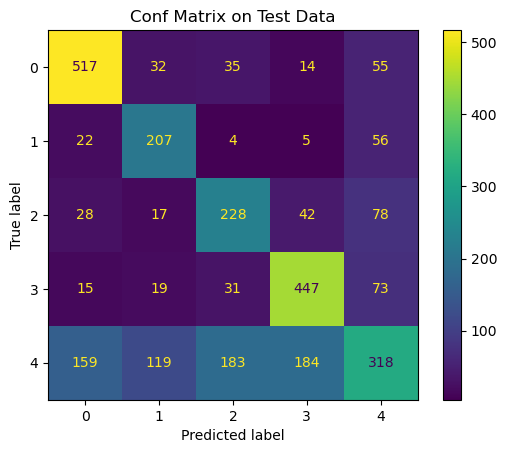

In [5]:
fit_score(MultinomialNB(), CountVectorizer(), class_4=True)

### 5-class Logistic Regression

Model: LogisticRegression(n_jobs=-1, random_state=0)
Vectorizer: TfidfVectorizer(max_features=1500)
Train accuracy: 68.3%
Test accuracy: 59.3%
Test loss: 0.980


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       653
           1       0.62      0.49      0.55       294
           2       0.52      0.41      0.46       393
           3       0.68      0.66      0.67       585
           4       0.49      0.57      0.53       963

    accuracy                           0.59      2888
   macro avg       0.60      0.57      0.58      2888
weighted avg       0.60      0.59      0.59      2888



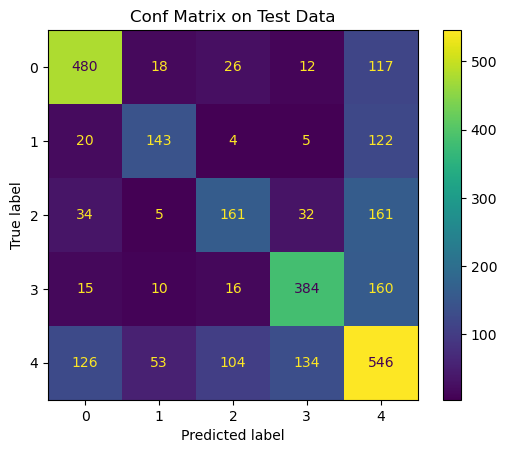

In [6]:
fit_score(LogisticRegression(max_iter=100, random_state=random_state, n_jobs=-1), TfidfVectorizer(max_features=1500), class_4=True)

Test accuracies for both Multinomial Naive Bayes and Logistic Regression were under 60%. We also tested other modeling algorithms and hyperparameter combinations, but we consistently plateaued at 60%. Our lowest log loss was 0.98

### Drop Class 4
In the above confusion matrices, you can see that the model struggled with the "General Pathological" class.
Given that the intention of our model is to specifically bucket medical text for specific medical fields, we felt it appropriate to drop this vague category.

### 4-class Naive Bayes

Model: MultinomialNB()
Vectorizer: CountVectorizer()
Train accuracy: 87.8%
Test accuracy: 79.8%
Test loss: 3.930


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       638
           1       0.74      0.79      0.76       304
           2       0.69      0.75      0.72       382
           3       0.87      0.85      0.86       603

    accuracy                           0.80      1927
   macro avg       0.78      0.79      0.79      1927
weighted avg       0.80      0.80      0.80      1927



C:\Users\heefj\anaconda3\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


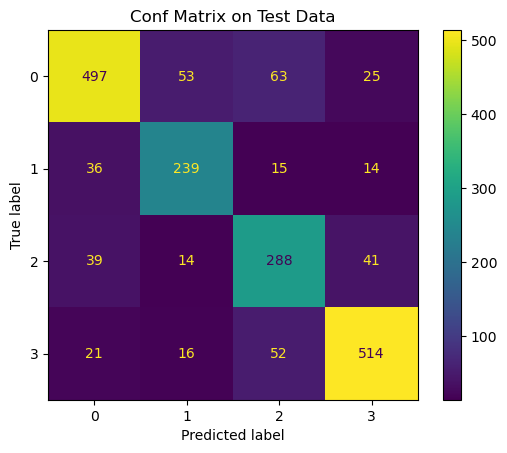

In [7]:
fit_score(MultinomialNB(), CountVectorizer())

### 4-class Logistic Regression

Model: LogisticRegression(n_jobs=-1)
Vectorizer: TfidfVectorizer(max_features=1500)
Train accuracy: 86.8%
Test accuracy: 80.5%
Test loss: 0.575


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       638
           1       0.79      0.73      0.76       304
           2       0.71      0.74      0.72       382
           3       0.85      0.87      0.86       603

    accuracy                           0.80      1927
   macro avg       0.79      0.79      0.79      1927
weighted avg       0.81      0.80      0.80      1927



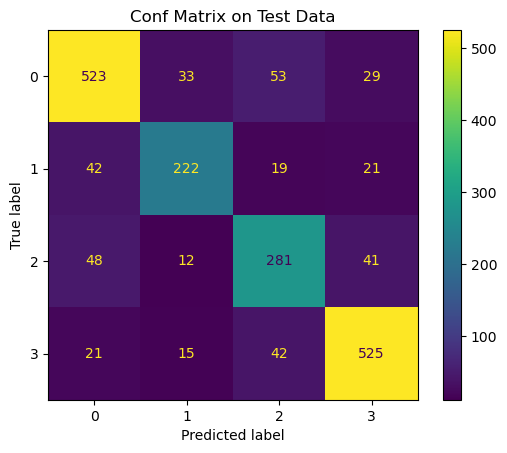

In [8]:
fit_score(LogisticRegression(n_jobs=-1), TfidfVectorizer(max_features=1500), random_state=random_state)

After dropping class 4, our two base models had an increase in test accuracy of 20%, raising the new benchmark to 80% accuracy and lowest log loss was 0.58.

### Incorporating Latent Semantic Analysis
- We used sklearn's [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [9]:
# create new 'df2' with only 4 classes
df2 = df[df['class'] < 4]

In [10]:
# vectorize
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df2.words)

# shape of input data
X.shape

(9633, 27268)

- Over 27k unique unigrams in our dataset. This number increases if we include bigrams and trigrams.
- We chose to include latent semantic analysis which uses methods of singular value decomposition to reduce the dimensionality of our vectorized data

In [22]:
# create our vectorizer
vectorizer = TfidfVectorizer()

# split train and test
X_train, X_test, y_train, y_test = train_test_split(df2.words, df2['class'], test_size=0.2, random_state=random_state)

# vectorize input data
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [31]:
# empty lists for later plotting
losses = []
accs = []

# look at LSA vals from 10-2010, incrementing by 50
for n in range(10, 2011, 50):
    # LSA
    svd = TruncatedSVD(n_components=n, random_state=random_state)

    # SVD transform the input data
    X_train_lsa = svd.fit_transform(X_train)
    X_test_lsa = svd.transform(X_test)
    
    logreg = LogisticRegression(random_state=random_state, n_jobs=-1)
    
    # fit nn
    logreg.fit(X_train_lsa, y_train)
    
    # get preds
    preds = logreg.predict_proba(X_test_lsa)
    
    # get loss and acc
    loss = log_loss(y_test, preds)
    acc = logreg.score(X_test_lsa, y_test)
    
    # append test loss and test acc
    losses.append(loss)
    accs.append(acc)

C:\Users\heefj\anaconda3\envs\tf-env\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


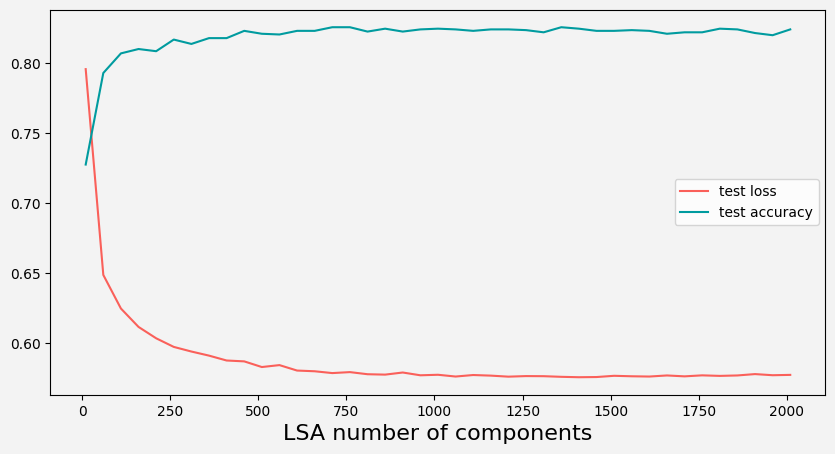

In [33]:
x = list(range(10, 2011, 50))

fig, ax = plt.subplots(figsize=(10,5), facecolor='#f3f3f3')
ax.set_facecolor('#f3f3f3')

plt.xlabel('LSA number of components', fontsize=16)

sns.lineplot(x=x, y=losses, label='test loss', color='#fa605a', ax=ax)
sns.lineplot(x=x, y=accs, label='test accuracy', color='#009b9f', ax=ax);

For Logistic Regression, increasing the number of components generally led to better accuracy and lower loss. We chose the value of __750__ components, as it seemed to capture all of the benefit without requiring more computing power.

In [ ]:
# LSA
svd = TruncatedSVD(n_components=750, random_state=random_state)

# SVD transform the input data
X_train_lsa = svd.fit_transform(X_train)
X_test_lsa = svd.transform(X_test)

Model: LogisticRegression(n_jobs=-1, random_state=0)
Vectorizer: TfidfVectorizer()
Train accuracy: 85.8%
Test accuracy: 82.7%
Test loss: 0.581


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       638
           1       0.85      0.75      0.80       304
           2       0.75      0.75      0.75       382
           3       0.86      0.88      0.87       603

    accuracy                           0.83      1927
   macro avg       0.82      0.81      0.82      1927
weighted avg       0.83      0.83      0.83      1927



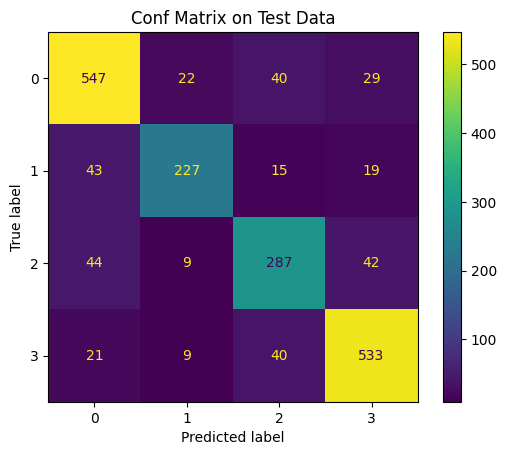

In [96]:
fit_score(LogisticRegression(random_state=random_state, n_jobs=-1), TfidfVectorizer(), lsa=True, lsa_components=750)

LogReg with 750 components gives new best test accuracy of __82.7%__. Our log loss is __0.58__

### K-Nearest Neighbors

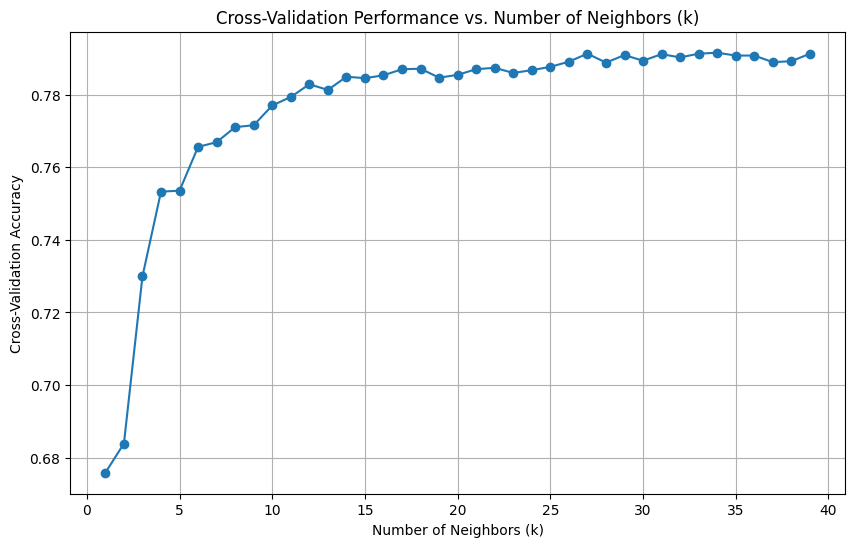

In [40]:
# Define a range of k values to test
k_values = list(range(1, 40))  # You can adjust this range

# Initialize lists to store cross-validation scores
cv_scores = []

# Perform k-fold cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Performance vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show() 

After 20 neighbors, the increase in accuracy is diminishing.

Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=20)
Vectorizer: TfidfVectorizer()
Train accuracy: 81.4%
Test accuracy: 78.5%
Test loss: 0.934


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       638
           1       0.81      0.67      0.73       304
           2       0.78      0.65      0.71       382
           3       0.80      0.87      0.83       603

    accuracy                           0.79      1927
   macro avg       0.79      0.76      0.77      1927
weighted avg       0.79      0.79      0.78      1927



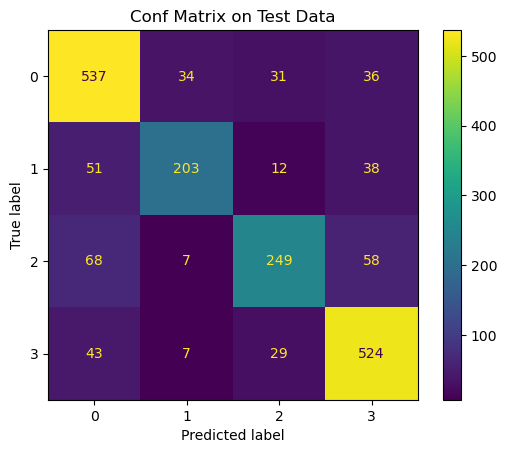

In [11]:
# best KNN
fit_score(KNeighborsClassifier(n_neighbors=20, n_jobs=-1), TfidfVectorizer())

Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=20)
Vectorizer: TfidfVectorizer()
Train accuracy: 69.4%
Test accuracy: 66.5%
Test loss: 1.070


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.55      0.90      0.68       638
           1       0.78      0.55      0.65       304
           2       0.71      0.48      0.57       382
           3       0.89      0.59      0.71       603

    accuracy                           0.66      1927
   macro avg       0.73      0.63      0.65      1927
weighted avg       0.72      0.66      0.66      1927



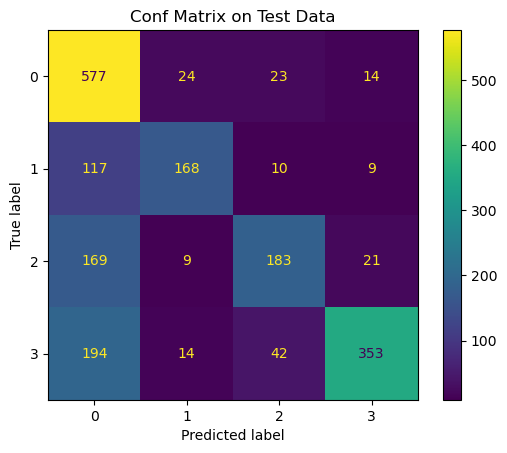

In [12]:
# best KNN with LSA
fit_score(KNeighborsClassifier(n_neighbors=20, n_jobs=-1), TfidfVectorizer(), lsa=True, lsa_components=750)

- LSA seems to hurt KNN
- Best KNN has a test accuracy of __78.5%__ and a log loss of __0.93__

### Decision tree, Random forest
- We played with many different hyperparameters for trees, and found they consistently performed worse than other algorithms.

Model: DecisionTreeClassifier(max_depth=25, random_state=0)
Vectorizer: TfidfVectorizer()
Train accuracy: 93.5%
Test accuracy: 61.3%
Test loss: 12.623


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       638
           1       0.45      0.49      0.47       304
           2       0.44      0.44      0.44       382
           3       0.75      0.69      0.72       603

    accuracy                           0.61      1927
   macro avg       0.58      0.58      0.58      1927
weighted avg       0.62      0.61      0.61      1927



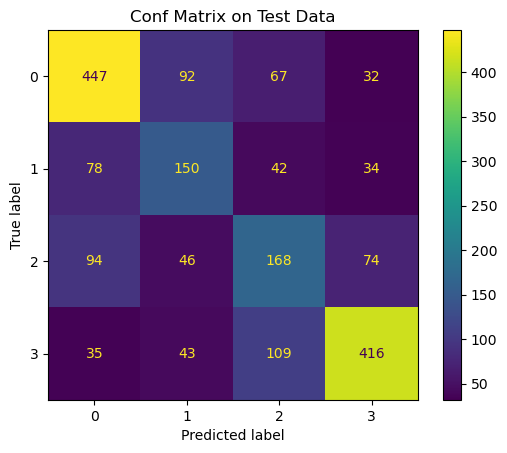

In [13]:
# decision tree
fit_score(DecisionTreeClassifier(random_state=random_state, max_depth=25), TfidfVectorizer(), lsa=True, lsa_components=750)

Model: RandomForestClassifier(random_state=0)
Vectorizer: TfidfVectorizer()
Train accuracy: 93.6%
Test accuracy: 70.8%
Test loss: 0.980


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       638
           1       0.63      0.47      0.54       304
           2       0.62      0.56      0.59       382
           3       0.76      0.82      0.79       603

    accuracy                           0.71      1927
   macro avg       0.68      0.66      0.67      1927
weighted avg       0.70      0.71      0.70      1927



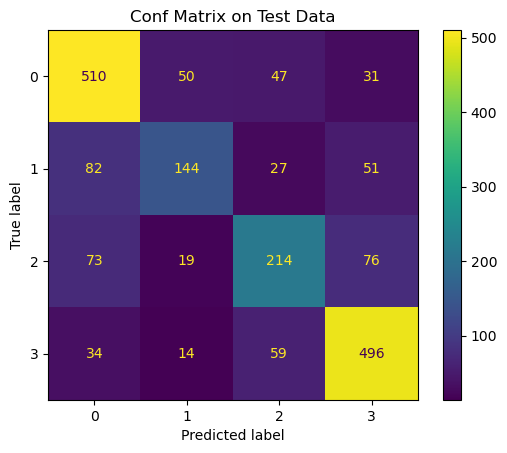

In [14]:
# random forest
fit_score(RandomForestClassifier(random_state=random_state), TfidfVectorizer(), lsa=True, lsa_components=750)

- As shown above, trees performed noticeably worse than other algorithms, only achieving a max test accuracy of __70.8%__ and a min log loss of __0.98__

### XGBoost

C:\Users\heefj\anaconda3\envs\tf-env\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Vectorizer: TfidfVectorizer()
Train accuracy: 93.6%
Test accuracy: 73.1%
Test loss: 1.127


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       

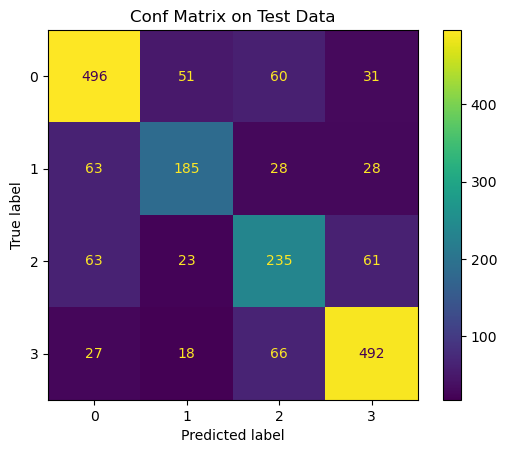

In [15]:
# xgboost
fit_score(XGBClassifier(random_state=random_state), TfidfVectorizer(), lsa=True, lsa_components=750)

Similar to RandomForest, XGBoost only achieved an accuracy of __73.1%__ with a min log loss of __1.13__

### Stacking Classifier

In [16]:
# build stacking classifier
stack = StackingClassifier([
    ('knn', KNeighborsClassifier(n_neighbors=20)),
    ('logreg', LogisticRegression(max_iter=1000, penalty=None))
])

We tested many different stacking combinations, and found that KNN with LogReg produced the best results

Model: StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=20)),
                               ('logreg',
                                LogisticRegression(max_iter=1000,
                                                   penalty=None))])
Vectorizer: TfidfVectorizer()
Train accuracy: 87.5%
Test accuracy: 79.9%
Test loss: 0.578


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       638
           1       0.79      0.72      0.75       304
           2       0.74      0.72      0.73       382
           3       0.84      0.87      0.86       603

    accuracy                           0.80      1927
   macro avg       0.79      0.78      0.79      1927
weighted avg       0.80      0.80      0.80      1927



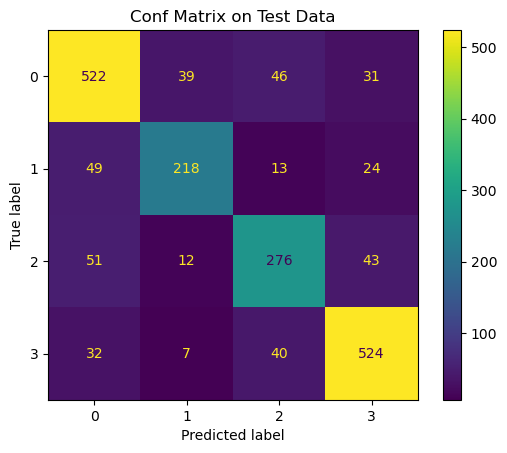

In [17]:
fit_score(stack, TfidfVectorizer())

C:\Users\heefj\anaconda3\envs\tf-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\heefj\anaconda3\envs\tf-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Model: StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=20)),
                               ('logreg',
                                LogisticRegression(max_iter=1000,
                                                   penalty=None))])
Vectorizer: TfidfVectorizer()
Train accuracy: 84.9%
Test accuracy: 77.5%
Test loss: 0.665


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       638
           1       0.76      0.64      0.70       304
           2       0.71      0.69      0.70       382
           3       0.84      0.85      0.84       603

    accuracy                           0.77      1927
   macro avg       0.77      0.75      0.76      1927
weighted avg       0.77      0.77      0.77      1927



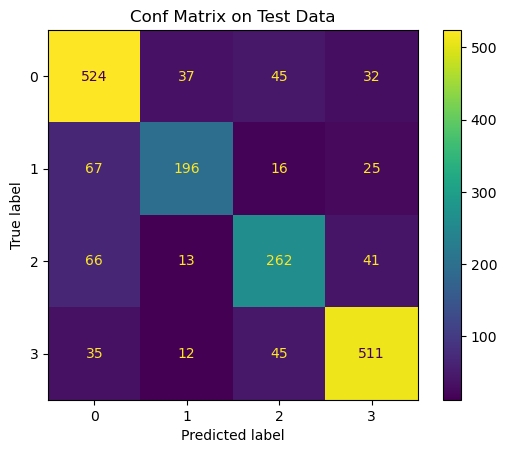

In [18]:
# incorporating LSA
fit_score(stack, TfidfVectorizer(), lsa=True, lsa_components=750)

Best stacking classifier had an accuracy of __79.9%__ and a log loss of __0.58__

### Neural Network

In [19]:
# make sure GPU is available for training NNs
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [20]:
# function to build a keras model
def build_model(input_dim, node_list):
    '''
    Build and return a keras NN with a specified node count for each hidden layer.
    
    Parameters:
    node_list - list where nth index value corresponds to nth hidden layer node count
    
    Returns:
    model - a keras NN
    
    '''
    
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    
    # add Dense hidden layers
    for node in node_list:
        # dense layer
        model.add(Dense(node, activation=relu))
        
        # standardize layer's weights
        model.add(BatchNormalization())
        
        # 50% dropout
        model.add(Dropout(0.5))
        
    # output layer - 4 possible classes
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [77]:
# add early stopping -> if model doesn't decrease val_loss every 5 epochs, exit the fitting process
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [78]:
# create our vectorizer
vectorizer = TfidfVectorizer()

In [79]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(df2.words, df2['class'], test_size=0.2, random_state=random_state)

# vectorize input data
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [81]:
losses = []
accs = []

# look at LSA vals from 10-2010, incrementing by 50
for n in range(10, 2011, 50):
    # LSA
    svd = TruncatedSVD(n_components=n, random_state=random_state)

    # SVD transform the input data
    X_train_lsa = svd.fit_transform(X_train)
    X_test_lsa = svd.transform(X_test)
    
    # create the KerasClassifier, use build_model to create our model
    nn = KerasClassifier(model=build_model(X_train_lsa.shape[1], [100, 100]), epochs=100, batch_size=32, optimizer=Adam(),
                         callbacks=[early_stopping], validation_split=0.2, verbose=0, loss='sparse_categorical_crossentropy')
    
    # fit nn
    nn.fit(X_train_lsa, y_train)
    
    # append val_loss and val_acc from last epoch
    losses.append(nn.history_['val_loss'][-1])
    accs.append(nn.history_['val_accuracy'][-1])
    
    # free up GPU memory
    backend.clear_session()

Epoch 23: early stopping
Epoch 28: early stopping
Epoch 27: early stopping
Epoch 19: early stopping
Epoch 19: early stopping
Epoch 13: early stopping
Epoch 12: early stopping
Epoch 15: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 10: early stopping
Epoch 9: early stopping
Epoch 10: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping


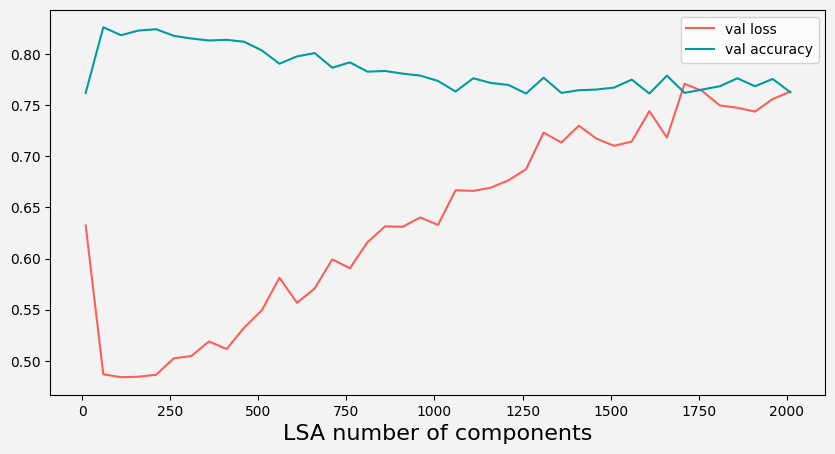

In [84]:
x = list(range(10, 2011, 50))

fig, ax = plt.subplots(figsize=(10,5), facecolor='#f3f3f3')
ax.set_facecolor('#f3f3f3')

# plt.title('')
plt.xlabel('LSA number of components', fontsize=16)

sns.lineplot(x=x, y=losses, label='val loss', color='#fa605a', ax=ax)
sns.lineplot(x=x, y=accs, label='val accuracy', color='#009b9f', ax=ax)

plt.savefig('../images/LSA', transparent=True);

Contrast to Logistic Regression, increasing n_components resulted in worse performance for the NN.
Best LSA components for NN was around __100__.

In [85]:
# LSA with 100 components
svd = TruncatedSVD(n_components=100, random_state=random_state)

# SVD transform the input data
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

# further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [86]:
# create the KerasClassifier, use build_model to create our model
nn = KerasClassifier(model=build_model(X_train.shape[1], [100, 100]), epochs=100, batch_size=32, optimizer=Adam(),
                     callbacks=[early_stopping], validation_split=0.2, verbose=1, loss='sparse_categorical_crossentropy')

In [87]:
# fit nn
nn.fit(X_train, y_train, validation_data=(X_val, y_val))

# free up GPU memory
backend.clear_session()

Epoch 1/100
193/193 [==============================] - 3s 11ms/step - loss: 1.4353 - accuracy: 0.4705 - val_loss: 1.2254 - val_accuracy: 0.4176
Epoch 2/100
193/193 [==============================] - 1s 8ms/step - loss: 0.8989 - accuracy: 0.6643 - val_loss: 0.8898 - val_accuracy: 0.6790
Epoch 3/100
193/193 [==============================] - 2s 8ms/step - loss: 0.7633 - accuracy: 0.7240 - val_loss: 0.5934 - val_accuracy: 0.8035
Epoch 4/100
193/193 [==============================] - 1s 8ms/step - loss: 0.7090 - accuracy: 0.7495 - val_loss: 0.5162 - val_accuracy: 0.8256
Epoch 5/100
193/193 [==============================] - 2s 8ms/step - loss: 0.6638 - accuracy: 0.7687 - val_loss: 0.5066 - val_accuracy: 0.8262
Epoch 6/100
193/193 [==============================] - 2s 8ms/step - loss: 0.6214 - accuracy: 0.7854 - val_loss: 0.5019 - val_accuracy: 0.8204
Epoch 7/100
193/193 [==============================] - 2s 8ms/step - loss: 0.5980 - accuracy: 0.7859 - val_loss: 0.4887 - val_accuracy: 0.828

In [88]:
nn.score(X_test, y_test)

61/61 [==============================] - 0s 3ms/step


0.815256875973015

Best NN test accuracy was __81.5%__

In [92]:
log_loss(y_test, nn.predict_proba(X_test))

61/61 [==============================] - 0s 4ms/step


0.5073877937792166

Our best NN had a test accuracy of __81.5%__ and a log loss of about __0.51__

## Conclusion

We decided to recommend the neural network as our best model, as it had the lowest log loss of all models by quite a large margin. The LSA Logistic Regression had a slightly higher test accuracy at 82.7%, but we felt like prioritizing a lower loss would lead to better generalization on unseen data.

### Final Recommendation: The Disease Deducer

- A neural network with 2 stacks of [100-node hidden layers, batch normalization, and 50% dropout]. We used the Adam optimizer with a batch size of 32, and latent semantic analysis with 100 components.
- This model achieved a classification accuracy of __81.5%__ on unseen data, and a log loss of __0.507__.
